<h1><strong> Data Modeling</strong> </h1><br><br>

<strong>📌 Note </strong>
<p>As a refresher we have cleaned the dataset by dropping all null values as this was seen as the best way to improve accuracy for our models that we are going to generate below. We have also decided to log(x+1) the skewed distribution of Arrival Delay in Minutes and Departure Delay in Minutes. Additonally we have also scaled the data using Standard Scaler. We did some correlation analysis and regression analysis on the variables which we then later tested for their feature importance for modeling using RFECV. Lastly, all will be kept except the ID column as the ID column serves no significant importance to our Target Variable, <i> satisfaction </i>.  </p> <br>

<strong>🎯 Objectives </strong> 
<p><li>1. Perform regression(s) – predict the independent attribute/target with the help of the information contained in the other attributes. </li>
  <li>  2. Perform k-means clustering to identify the different clusters of passengers within the data.</li>
    </p>
<br> 
<strong>🔃 Changes Made  </strong> 
<p>
<div><u>One Hot Encoding </u>
    <li>1. More attributes have been one hot encoded. Further explanation will "be given below</li> <u>Classifciation Models</u><u>Log</u><li>2. log(x+1) used instead of log()</li></</div>

<br>
<br>

<h1> <strong> Summary </strong> </h1>

- Should we use all attributes or CAN we use all attributes?
ANS :
- Justify why this regression method is used, why the selected attributes are appropriate for predicting the target. 
ANS : 
- Show the equation of the model and explain its significance.
ANS : 
- Are you satisfied with the performance of the model(s)?
ANS :

- Should we use all attributes or CAN we use all attributes?
ANS :
- Justify why the selected attributes and parameters are used. 
ANS :
- Identify the different clusters. 
ANS : 

<br>
<br>

<h1> <strong> Tasks </strong> </h1>

<br>
<br>

-----------------------

<br>
<br>

<h3> <strong>1. Loading The Data </strong> </h3>

<br>

<strong> Importing the dataset & Libraries </strong>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


from sklearn.cluster import KMeans

import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./DataSet.csv', delimiter=",", low_memory=False)

In [3]:
df.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

<br>
<br>

<h3> <strong>2. Cleaning The Data </strong> </h3>

<br>

<strong> Cleaning the dataset </strong>

In [3]:
# It is essential that we are to run the commands in this order 
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
# Removing irrelevant data
df.drop("id", axis=1, inplace=True)
df.loc[df["Customer Type"] == "loyal", "Customer Type"] = "Loyal Customer"
df.loc[df["Customer Type"] == "disloyal Customer", "Customer Type"] = "Disloyal Customer"
df.loc[df["Customer Type"] == 'DISLOYAL CUSTOMER', "Customer Type"] = "Disloyal Customer"
df.loc[df["Customer Type"] == 'Disloyal', "Customer Type"] = "Disloyal Customer"
df.loc[df['Baggage handling'] == "-", 'Baggage handling'] = 0 # not applicable data types will be converted 0 
df['Baggage handling'] = df['Baggage handling'].astype(int) # Converting  string data to numerical data 
df['Baggage handling'].unique() #outcome 
Numeric_columns = [ # columns with outliers excluding Arrival Delay in minutes and Departure Delay as some time planes might be grounded due to bad weather etc. In this case we would need to research and select the maximum arrival and departure delay time. 
'Ease of Online booking','Age'
]

df.drop(df[df["Departure Delay in Minutes"] > 360].index, inplace=True) # Logistic regression and classification models increase in accuracy within this specific time frame, also based on many different airlines the general delay time is around 3 - 5 hours. As such,  we will choose 6 hours as a worse case scenario and the maximum an airline can delay their flights 
df.drop(df[df["Arrival Delay in Minutes"] > 360].index, inplace=True)

#removing the outliers
def outliers(data1,columns):
        Q1 = data1[columns].quantile(0.25)
        Q3 = data1[columns].quantile(0.75)
        IQR= Q3-Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
     
        ls = data1.index[(data1[columns]< lower_bound) | (data1[columns]>upper_bound)]
     # Using IQR to remove the outliers, data outside the upperbound would be remove 
        return ls


def remove(data1,ls):
    ls=sorted(set(ls))
    data1 = data1.drop(ls,inplace=True)
    return data1


index_list=[]

for columns in Numeric_columns:
    index_list.extend(outliers(df,columns))
                
remove(df,index_list)

df.drop(df.loc[df['Age']<0].index, inplace=True)
df.drop(df.loc[df['Departure/Arrival time convenient']<0].index, inplace=True)
df.drop(df.loc[df[ 'Inflight wifi service']<0].index, inplace=True)
df=df.astype({'Baggage handling':'int64','Gate location':'int64','Departure/Arrival time convenient':'int64','Ease of Online booking':'int64'})


<br>
<br>
<h3> <strong>3. 📐 Scaling & Standardsing data  </strong> </h3>
<br>
<br>
<strong>📌 Note </strong>
<p> It is of note that not all machine learning models benefits from Scaling, some notable ones are XGB and Adaboost (which are under the decision tree and ensemble techniques method). Those who benefits are models which use the Gradient Descend algorithms like GradientBoostingRegressor. </p>
<br>
<p> <strong> Why do we need Feature Scaling ? </strong> </p>
<p> Different Datasets have different units of measurement, where in one column posses Flight Distance in the thousands, another might posses columns which range in the tens such as ratings. This is a problem as some models might place higher emphasis on columns with higher scale, causing inaccuracy in the model if scaling is not implemented. Thus, to bring down the attributes to the same plane Scaling is implemented. MinMax scaler is not implemented as the upper limits are not known. This refers to values such as Age, Arrival Delay in Minutes, Departure Delay in Minutes and Flight Distance. Our data also consist of a normal distribution after logging. Standardisation is also suitable for models which uses linear regresssion which assumes a normal distribution.
    MinMaxScaler may be used when the upper and lower boundaries are well known from domain knowledge (e.g. pixel intensities that go from 0 to 255 in the RGB color range). </p>
<br>

<strong> Problems with Log Transformation & Solution</strong>
<p> Log Transfomation however cannot log values that are 0, log(0) produces a value that is undefined. There are unfortunately presence of 0 values in the Arrival Delay in Minutes and Departure Delay in Minutes, thus implementing vanilla log transformation is not going to work. To deal with that log(x+1) will be used</p> 
<br>
<strong> Procedure </strong>
<p> To ensure that the model treat each of these variables equally, we will introduce log transformation for reducing the skewness of the data and scaling using the Standard Scaler. </p>
<p> <li> 1. Log the Columns needed </li> <li> 2. Scale all columns as needed using standard scaler </li></p>
<br>

In [4]:
# Log Departure Delay in Minutes
df['Departure Delay in Minutes'] = np.log1p(df['Departure Delay in Minutes'])

# Log Arrival Delay in Minutes 
df['Arrival Delay in Minutes'] = np.log1p(df['Arrival Delay in Minutes'])


# Log Flight Distance
df['Flight Distance'] = np.log(df['Flight Distance']) # because lowest value is not 0 but 31

In [5]:
df['Average_satisfaction'] = df[[  'Inflight wifi service', 'Ease of Online booking', # creating a new column that calculates average rating 
    'Gate location', 'Food and drink', 'Online boarding',
    'Seat comfort', 'Inflight entertainment', 'On-board service',
    'Leg room service', 'Baggage handling', 'Checkin service',
    'Inflight service', 'Cleanliness','Departure/Arrival time convenient']].sum(axis=1)/14

In [6]:
def scaling(data):
    num_columns = [ # Scaling all quantitative columns using Standard Scaler . Does not make sense to scale a categorial variables. 
        'Age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes','Average_satisfaction'
    ]

    for num_column in num_columns:
        scaler = StandardScaler() # initialising Standard Scaler 
        data[num_column] = scaler.fit_transform(data[[num_column]])
    return data

<br>
<br>

<strong> Feature Leakage </strong>

<p> From the data itself, we can also deduce the possibility of data leakage. The data or feature leakage which is the likert variables may have, through subjective analysis, play a part in the satisfaction of the customers. This could mean that just by using the likert data itself we could possibly determine the satisfaction. This is not good for our modeling as it might causes predictive models to appear more accurate than they really are. As such, to further validate our point we plotted Average satisfaction against satisfaction through a table. As we can see, higher ratings generally results is more customers being satisfied and lower ratings generallly mean dissatisfaction. This comfirms our assumptions and supports our deduction that the likert varaibles serve as a form of data leakage. </p>

In [146]:
df[["satisfaction", "Average_satisfaction"]].groupby(['satisfaction'], as_index=False).mean().sort_values(by='satisfaction', ascending=False)

,satisfaction,Average_satisfaction
1,satisfied,3.615588
0,neutral or dissatisfied,2.953884


<br><br><strong> Solution </strong>
<p>  To eliminate as much feature leakge, these features were specifically chosen to reduce the amount of feature leakage towards the target variable <i> satisfaction </i>. As observed, the chosen features are of those taken off-flight (we did not include any on flight services). By taking off-flight services we hope to 

<br>
<br>

In [7]:
df_SS=df.copy()
processed_data = scaling(df_SS)


processed_data_KM = processed_data[['Age', 'Flight Distance', 'Departure Delay in Minutes',"Arrival Delay in Minutes","Average_satisfaction"]]

processed_data_KM['Total Delay'] = processed_data_KM[['Departure Delay in Minutes','Arrival Delay in Minutes']].sum(axis=1)

processed_data_LR = processed_data[['Age', 'Flight Distance', 'Departure Delay in Minutes',"Arrival Delay in Minutes","Gender", "Customer Type", "Type of Travel", "Class",'Average_satisfaction']] # Linear Regression

processed_data = processed_data[["Gender", "Customer Type", "Type of Travel", "Class",'Age', 'Flight Distance', 'Departure Delay in Minutes',"Arrival Delay in Minutes","Online boarding",'Ease of Online booking','Gate location','Departure/Arrival time convenient','Checkin service',"satisfaction"]]


<br>

<br>

<h3> <strong>5. Clustering </strong> </h3>

<br>
<strong>What is Clustering ? </strong>
<p>Clustering refers to the grouping of objects with similar characteristics. When it comes to data the process of clustering invloves the partitioning of data into different groups.</p>
<br>   
<strong> What are the benefits of clustring in our dataset ? </strong>
<p> Clustering allows the examination of relationships between different demographics For instance, utilising clustering methods can help us identify distinct groups based on differnt factors such as Age , overall satisfaction etc. The factors analysed through clustering can have a big impact on our understanding of the data as well as give us a deeper insight for the data </p> <br>

<strong>Elbow Method For Identification Of Optimal Number Of Clusters </strong>
<p> The Elbow Methods selects the optimal number of clusters by fitting the model with a range of values for K. The the point of inflection on the curve) is a good indication that the underlying model fits best at that point. Other than the normal Kmeans clustering model we will use another library YellowBrick to better visualise the point of infliction. As we can see below the optimal number of clusters is 3. We will procceed and plot the data in 2D </p>

<br>

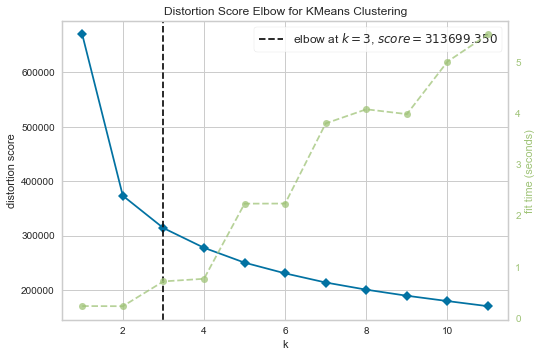

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
from yellowbrick.cluster import KElbowVisualizer

PD_Cluster = processed_data_KM[["Flight Distance","Total Delay", "Age","Average_satisfaction"]]

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12), random_state=2869,n_jobs=4)  


visualizer.fit(PD_Cluster)        # Fit the data to the visualizer # These Four chosen cause ratings are ordinal
visualizer.show()

<br>

<br><br><strong> Plotting the Clusters </strong>

<strong> Plotting in 3D </strong>

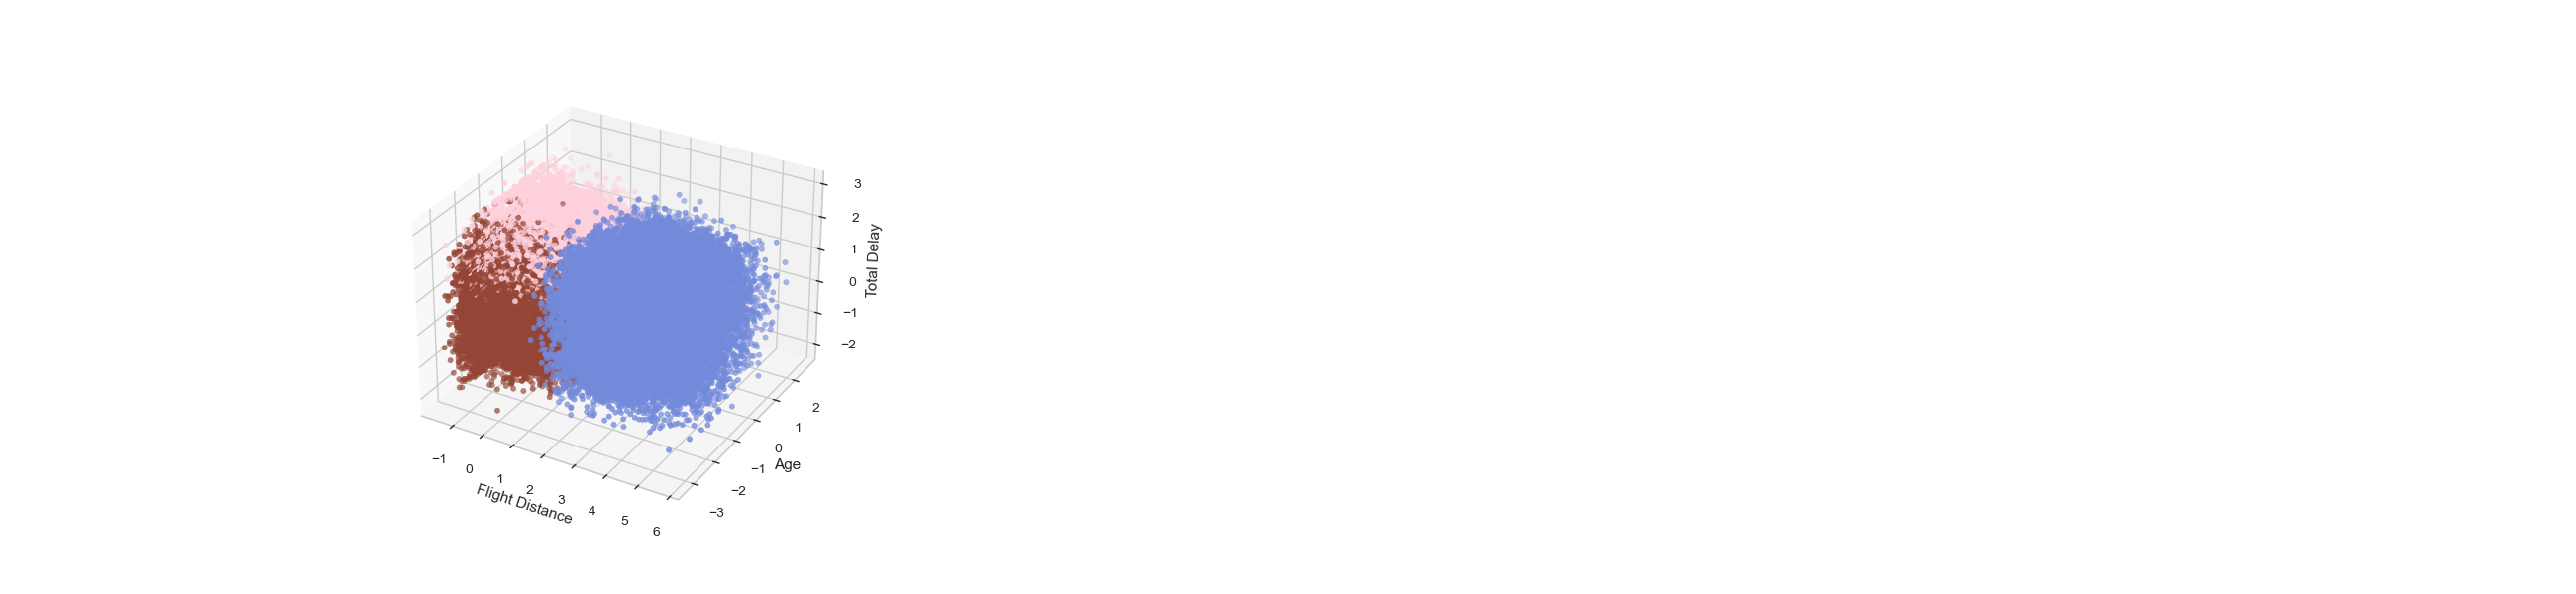

In [9]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget


kmeans = KMeans(n_clusters=3, random_state=2869)

colors = ['#ffd1dc', '#954535', '#738adb']
PD_Cluster['cluster'] = kmeans.fit_predict(PD_Cluster[["Flight Distance","Total Delay", "Age","Average_satisfaction"]])
PD_Cluster['c'] = PD_Cluster.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})


fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')



ax.scatter(PD_Cluster['Total Delay'],PD_Cluster['Average_satisfaction'], PD_Cluster['Age'], c=PD_Cluster.c, s=15)
ax.set_xlabel('Flight Distance')
ax.set_ylabel('Age')
ax.set_zlabel('Total Delay')
plt.show()

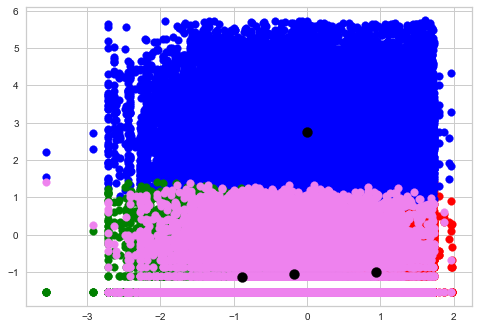

In [10]:
my_kmeans = KMeans(n_clusters=4, init='random', n_init=150 ,max_iter=1000,random_state=2869) 
#my_kmeans.fit(PD_Cluster) 

label = my_kmeans.fit_predict(PD_Cluster)

#PD_Cluster['Cluster'] = my_kmeans.labels_

PD_Cluster= PD_Cluster.iloc[:].values


plt.scatter(PD_Cluster[label == 0, 0], PD_Cluster[label == 0, 1], s = 60, c = 'red', label = 'Cluster1')
plt.scatter(PD_Cluster[label == 1, 0], PD_Cluster[label == 1, 1], s = 60, c = 'blue', label = 'Cluster2')
plt.scatter(PD_Cluster[label == 2, 0], PD_Cluster[label == 2, 1], s = 60, c = 'green', label = 'Cluster3')
plt.scatter(PD_Cluster[label == 3, 0], PD_Cluster[label == 3, 1], s = 60, c = 'violet', label = 'Cluster4')

            
plt.scatter(my_kmeans.cluster_centers_[:, 0], my_kmeans.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')
 

plt.show()

<strong> Cluster Analysis </strong>
<p> From the clustering above we ca

<br>

<br>
<br>

<h3> <strong>3.5 Label Encoding  & One Hot Encoding</strong> </h3>

<br>

<p>Label Encoding <i> satisfaction </i> to 1 and 0s. as well as One Hot Encoding all categorial variables except rating columns. </p>  

In [10]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

processed_data= pd.get_dummies(processed_data,columns=["Gender", "Customer Type", "Type of Travel", "Class","Online boarding",'Ease of Online booking','Gate location','Departure/Arrival time convenient','Checkin service'])
processed_data_LR =pd.get_dummies(processed_data_LR, columns=["Gender", "Customer Type", "Type of Travel", "Class"])
processed_data["satisfaction"] = label_encoder.fit_transform(processed_data["satisfaction"])

<br>

<br>

<h3> <strong>4. Splitting the Data </strong> </h3>



<br>

In [11]:
from xgboost import XGBClassifier  
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression # Libaries to invite
from sklearn.linear_model import LinearRegression

<br><br><strong> Logistic Regression </strong>

In [10]:
modified_Log = processed_data.copy()
y = processed_data["satisfaction"].to_numpy() # Splitting and Shuffling the dataset
del processed_data['satisfaction']
X = processed_data.to_numpy()
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.8,random_state=2869)

<br><br><strong> Linear Regression </strong>

In [14]:
modified=processed_data_LR.copy()
y_LR = processed_data_LR["Average_satisfaction"].to_numpy() # Splitting and Shuffling the dataset
del processed_data_LR['Average_satisfaction']
X_LR = processed_data_LR.to_numpy()

X_train_LR,X_test_LR,y_train_LR,y_test_LR = train_test_split(X_LR,y_LR, train_size=0.8,random_state=2869)

<br>
<br>

<h3> <strong>4.5 RFECV Revisited </strong> </h3>

<br>

<strong> Context </strong>
<p> In the Previous workbook we did RFECV for Random Forest. This time we would be using it for other classfication and regression algorithms <p><br>
    
<strong> so how does it work </strong>
<p>RFE uses the models Coef_ or feature_importance_ attributes to rank the features RFE then recusviely elimates a small number of feature per loop in attempts to eliminate dependencies and collinearity that may exist in the model <p>
    

<BR><br><strong> Linear Regression </strong> <br>

In [49]:
from yellowbrick.model_selection import RFECV

visualizer = RFECV(LinearRegression(),cv=5) # can put scoring = "accuracy" etc
visualizer.fit(X_LR, y_LR)                   # Fit the data to the visualizer

RFECV(ax=<Axes3DSubplot:xlabel='Flight Distance', ylabel='Age'>, cv=5,
      estimator=LinearRegression())

In [27]:
from sklearn.feature_selection import RFECV
modified['Total Delay'] = modified[['Departure Delay in Minutes','Arrival Delay in Minutes']].sum(axis=1)
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(modified.iloc[:, :-1], modified.iloc[:, -1], train_size = 0.80)
X_LR, y_LR = X_train_LR, y_train_LR
lin_reg = LinearRegression()
rfe_mod = RFECV(lin_reg,cv=5) 
myvalues=rfe_mod.fit(X_LR,y_LR) 
myvalues.support_
myvalues.ranking_ 
selected = pd.DataFrame({'Feature':list(X_train_LR.columns),'Ranking':myvalues.ranking_})
selected.sort_values(by="Ranking")

,Feature,Ranking
2,Departure Delay in Minutes,1
3,Arrival Delay in Minutes,1
12,Class_Eco,2
1,Flight Distance,3
9,Type of Travel_Business travel,4
8,Customer Type_Loyal Customer,5
10,Type of Travel_Personal Travel,6
4,Average_satisfaction,7
0,Age,8
13,Class_Eco Plus,9


<br><br> <strong>Logistic Regression </strong> 

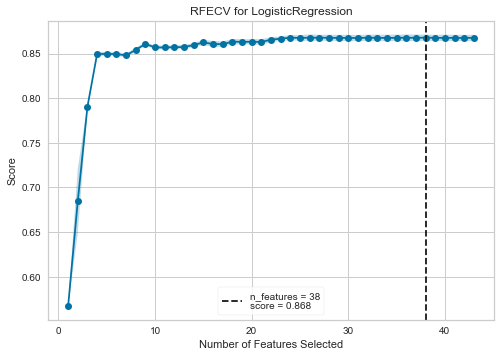

<AxesSubplot:title={'center':'RFECV for LogisticRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [11]:
from yellowbrick.model_selection import RFECV

rfe_mod = RFECV(LogisticRegression(),cv=5) 
myvalues=rfe_mod.fit(X,y) 
plt.title("RFECV for Logistic Regression")
myvalues.show() 

<br>

<br>

<h3> <strong>5. Model Development </strong> </h3><br>

<br><strong> Model selection </strong>

<p> The target variable that we are trying to predict is the satisfaction of the customer. To that end, we have "shown" and ran our models in different algorithms; the algorithm that learns the best between the variabels and is capable to preidct the outcome with the least amount of errors was selected as the best performing one </p>

In [ ]:


    Select the appropriate target and make predictions using the selected features from Task 2.
    - Build Linear & Logistic Regression models. -1
    - Show the equation for the respective models. -0
    - Explain the significance and the reliability of the predictors. 
    - Comment on the performance of the models. 
    - Ponder over if you should or can use all attributes (minus the target) in your modelling.



<br><h4> <strong>i. Logistic Regressions </strong> </h4>

<br><strong> What Is Logistic Regression </strong>
<p>When the dependent variable is discrete, the logistic regression technique is applicable. In other words, this technique is used to compute the probability of mutually exclusive occurrences such as pass/fail, true/false, 0/1, and so forth. Thus, the target variable can take on only one of two values, and a sigmoid curve represents its connection to the independent variable, and probability has a value between 0 and 1. </p><br>

<strong>How does Logistic regression apply to us ? </strong> 
<p> Since our dependent variable is dichotomous (binary) logistic regression would fit quite well within our requirements as we are to predict whether the customers are satisfied (1) or not satisfied (0).</p> <br>

<br><div style="text-align:center"><strong> Equation </strong></div>|
<div style=" height: 350px; text-align: center; padding: auto "><img  src= https://www.saedsayad.com/images/LogReg_1.png>
</div>

</div>
<p> 

The selected variables for Logistic Regression are ["Gender", "Customer Type", "Type of Travel", "Class",'Age', 'Flight Distance', 'Departure Delay in Minutes',"Arrival Delay in Minutes","Online boarding",'Ease of Online booking','Gate location','Departure/Arrival time convenient','Checkin service',"satisfaction"]

<br><strong> Equation </strong>

ln[Y(satisfaction)/(1−Y(satisfaction))]=5.62381029+0.512517(Online boarding_5)+0.281786( Departure/Arrival time convenient_5 )+0.268522(Class_Business)....

In [47]:
coeff_df = pd.DataFrame(processed_data.columns) # 
coeff_df.columns = ['Feature'] 
coeff_df["Coef"] = pd.Series(log.coef_[0])

coeff_df.sort_values(by='Coef', ascending=False)

,Feature,Coef
18,Online boarding_5,0.512517
36,Departure/Arrival time convenient_5,0.281786
10,Class_Business,0.268522
35,Departure/Arrival time convenient_4,0.252811
31,Departure/Arrival time convenient_0,0.204994
26,Gate location_1,0.185714
17,Online boarding_4,0.177747
22,Ease of Online booking_3,0.174528
9,Type of Travel_Personal Travel,0.163514
21,Ease of Online booking_2,0.155675


In [45]:
log.intercept_

array([5.62381029])

In [12]:
modified_Log = processed_data.copy()
y = processed_data["satisfaction"].to_numpy() # Splitting and Shuffling the dataset
del processed_data['satisfaction']
X = processed_data.to_numpy()
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.8,random_state=2869)

log = LogisticRegression()
log.fit(X_train, y_train)
y_pred_LR = log.predict(X_test)

print('Performance of Logistic Regression:\n')
print(confusion_matrix(y_test, y_pred_LR))
print(classification_report(y_test, y_pred_LR))
print('Accuracy:',accuracy_score(y_test, y_pred_LR))
print('Precision:',precision_score(y_test, y_pred_LR, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_LR, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_LR, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_LR))

Performance of Logistic Regression:

[[10130  1279]
 [ 1435  7407]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     11409
           1       0.85      0.84      0.85      8842

    accuracy                           0.87     20251
   macro avg       0.86      0.86      0.86     20251
weighted avg       0.87      0.87      0.87     20251

Accuracy: 0.8659819268184287
Precision: 0.8658034626485588
Recall: 0.8659819268184287
F1 Score: 0.8658405537682827
Cohen Kappa Score: 0.7270449799277205


<br>
<br>
<strong> Analysis Of The Performance Of Models </strong> 
<p>
<p>From the results above, it shows that the model has a good overall score. With the F1 Score and Cohen Kappa Score being relatively high we can deduce that the model does not have a class imbalance. This high score also allows us to be sure that there are little to none false positive and negatives which gives us a more reliable Accuracy score. The Accuracy score is also high at 87.5%. Due to the high overall score of the model, we can conclude that Logistic Regresssion is a good model for prediction and analysis. </p>

<br><strong>  Explain the significance and the reliability of the predictors. </strong>
<P>
<p> The most signficacnt predictor through the Coef was Online boarding, Departure/Arrival Time Convenient and Class_Business. As the coefficients represent the weight and significance of the predictors we can conclude that the top 5 -10 variables or those with positive correlation as essential to improving customer satisfaction. These variables would then be considered in the recommendations. <p> <br>

<br><strong> Should we & can we use all variables : No </strong>

No, we should not use all variables (despite RFECV showing all features should be used). As observed in part 3 where the models are processed, there is a section where only selected variables are chosen. These variables are preflight varaibles like Age, Customer Type, Flight Distance, Online-boarding, Gate Location etc. These variables are chosen to reduce feature leakage towards the target variable <i> satisfaction </i>. By reducing feature leakage we stand to reduce the correlation between the target and independent variables, allowing us to have a model that is not overly optimistic or completely invalid. Preflight variables are chosen because to of an Assumption and a requirement by the problem statement.
- Airline X wants to understand how the profiles of the passengers and their ratings of different services could possibly affect the overall satisfaction level
- Assumption 1 that the data for preflight service was taken before the flight and onflight-services after the flight
- Assumption 2 that Airline X would predict using the accquired data before the flight.

There are many parts of the puzzles such as assumption, best practices (reduction of feature leakage) and problem statement.  
From the problem statement what we can deduce is that Airline X wanted to use the given data to predict the overall satisfaction of their customers. However, the data of certain service could not be accquired, such as onflight-services etc. This brings us to our assumption of when the data was noted. In essence data points such as flight distance, Age , Customer Type, Gate Location, online-boarding are all predetermined from the time the user registers for a flight, thus the preflight data is assumed to be taken before the flight. The second assumption is that Airline X time of prediction was before the flight. This means that the only accquired data was the predetermined variables (Flight Distance). 

This brings us to the theory. Since our dataset consist of all variables those onflight and offlight (pre-determined) the questions now lie whether we should use all variables ? As discussed above the answer is No, this is because of the feature leakage that occurs when we use data that is not known before the flight. If our assumption 1 & 2 stands true then it would mean that if we used all data points feature leakage would occur, ruining the model. The evidence behind the feature leakage could also be observed via the table we have created in part 3, with Average_satisfaction being much higher for satisfied  and lower for dissatisfied the model could use these features as a guage for whether the customers are satisfied or not. 

Thus, to eliminate or reduce feature leakage multiple sources (References), supports the practice of removing data that could not be known at the time of prediction and only focusing on the time we learned about a fact or observation rather than the time the observation occurred . Thus variables such as on-flight services are removed.


<br><br> <strong> Happy with the model ?
<p> I am satisfied with the model as it has shown a high overall performance of over 80 %. The model has low false positives and negatives as it has a high preciion and recall score followed by a high cohen kappa score of 0.72. This signifies that the model is accurate and its predictions and results on the shown accuray is reliable. <p> 

<br>

<br>

<h4><strong>ii. Linear Regression <strong></h4> <br>

<strong> What is Linear Regression </strong>
<p>Linear regression is a regression type model that estimates the relationship between independent variables and a dependent variable using a straight line. For our Linear Regression we would be trying to predict the Total Delay In Minutes against Flight Distance. Thus, the question we are trying to answer or relationship we are trying to analyse and predict is if The increase in Flight distance plays a part in Total Delay in Minutes. </p>

<br>

<div style="text-align:center"><strong> Equation | Flight Distance Against satisfaction </strong></div><br><br>
<div style=" height: 250px; text-align: center; padding: auto "><img  src= "http://science.clemson.edu/physics/labs/tutorials/excel/lrplot.gif" >
</div> 

The selected variables for Linear Regression are ["Gender", "Customer Type", "Type of Travel", "Class",'Age', 'Flight Distance', 'Departure Delay in Minutes',"Arrival Delay in Minutes","Online boarding",'Ease of Online booking','Gate location','Departure/Arrival time convenient','Checkin service',"satisfaction"] <br><br>

<strong> EQUATION </strong>

Y(Average_satifaction) = -0.174 + 0.02663662(Age) +   0.02503054(Flight Distance) + 0.018484(Departure Delay in Minutes) -0.07013395(Arrival Delay in Minutes) - 0.00448273(Gender_Female) + 0.00448273(0.004483) -0.14068984( Customer Type_Disloyal Customer) + 0.14068984(Customer Type_Loyal Customer ) + 0.01810571() -0.01810571() + 0.32887255(Class_Business) -0.14390576(Class_Eco) -0.1849668(Class_Eco Plus )

In [22]:
print(LR.intercept_)

-0.17485283771971932

In [43]:
coeff_df["Correlation"] = pd.Series(LR.coef_)
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
10,Class_Business,0.328873
7,Customer Type_Loyal Customer,0.140690
0,Age,0.026637
1,Flight Distance,0.025031
2,Departure Delay in Minutes,0.018484
8,Type of Travel_Business travel,0.018106
5,Gender_Male,0.004483
4,Gender_Female,-0.004483
9,Type of Travel_Personal Travel,-0.018106
3,Arrival Delay in Minutes,-0.070134


<br>

<strong> Model </strong>

In [21]:
modified=processed_data_LR.copy()
y_LR = processed_data_LR["Average_satisfaction"].to_numpy() # Splitting and Shuffling the dataset
del processed_data_LR['Average_satisfaction']
X_LR = processed_data_LR.to_numpy()

X_train_LR,X_test_LR,y_train_LR,y_test_LR = train_test_split(X_LR,y_LR, train_size=0.8,random_state=2869)

LR = LinearRegression() # Note: not much parameters here 
LR.fit(X_train_LR, y_train_LR) 
y_pred_LRR = LR.predict(X_test_LR)

import math
print('Performance of Linear Regression:\n')
print(f"Mean Squared Error: " , mean_squared_error(y_test_LR, y_pred_LRR))
print(f"Root Mean Squared Error: " ,math.sqrt(mean_squared_error(y_test_LR, y_pred_LRR)))
print(f"Mean Absolute Error: " , mean_absolute_error(y_test_LR, y_pred_LRR))

Performance of Linear Regression:

Mean Squared Error:  0.905680584063299
Root Mean Squared Error:  0.9516725193380856
Mean Absolute Error:  0.770046859343248
0.09423966762551184


<br><br><strong> Analysis </strong>
<p> From the regression model we can observe that the MSE and RMSE is low for the model. MSE or MSD  measure the amount of error in statistical models. It assesses the average squared difference between the observed and predicted values. (Frost, n.d.). This means that a low MSE would mean a lower average squared residual. meaning that the data falls within or close to the regression line decreasing the MSE.  Overall the model performance is good<p>

<br><br><strong>Should we use all variables ?</strong>
<p>
No we should not use all variables. Apart from the features which contribute to feature leakage, the chosen variables are Age', 'Flight Distance', 'Departure Delay in Minutes',"Arrival Delay in Minutes","Gender", "Customer Type", "Type of Travel", "Class",'Average_satisfaction'. These variables are chosen because they are preflight data and can contribute to the prediction of the target variable "Average_satisfaction". With regards to why Online-Boarding and such is not used is because of their direct correlation with Average_satisfaction. Average_satisfaction is the sum of all Ordinal variables including preflight data. Thus, preflight ordinal data cannot be used. The above categorial features will be converted via one hot encoding , (get_dummies version) for our Linear Regression models. 




</p><br><br>

<strong> Significance and reliability of predictors </strong>
<p>
<p> The most significant predictor is the Class_Buisness Customer_Type loyal and Age. From the coef analysis we have done 

<br><br><strong> Happy with the model ? </strong> <p>
    <p> The model shows a low MSE and RMSE score, this means that the model has little deviations from the estimated value. Thus I am happy with the model<p> 

<br>

<br>
<br><h3> <strong>Conclusion & 2 Recommendation </strong> </h3>
<p> Recommendation 1 Airline X should focus more on its online-boarding, its departure delay times and Buisness class as it is the most important feature when it comes to predicting customer satisfaction. 
Recommendation 2 Airline X should also focus more on its other services such as its checking service as it has a high negative impact on the customer satisfaction. More recovery efforts should be placed upon customer checking service if the airline wans to improve customer satisfaction.<p> Thus, while airline X has a good number of postive features which contribute to high satisfaction. Airline X also has a ton of negative feature which contributes to customer disatisfaction. The main concept for Airline X is that they have further room for improvement with regards to the postive features (best feature was only 0.5)  and they also need to pick up on their loose ends (most negative feature was -13) and improve upone these high unsatisfactory service <p> 

<br>

<br><strong> Personal Notes </strong>

- n_initint, default=10
    - Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
 <p>   
- max_iterint, default=300
    - Maximum number of iterations of the k-means algorithm for a single run
    <p>
-'weighted':
    - Calculate metrics for each label, and find their average 
    
   
